## Check pySPM version

In [1]:
import pySPM
print(pySPM.__version__)

0.6.2


In [ ]:
plt.close('all')

## Get list of SPM files in folder

In [3]:
import os

# Define the folder containing .spm files
folder_path = r"C:\Users\cobia\OneDrive - University of Cambridge\HF_Database\AFM\raw"

spm_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.spm')]
print(f"Found {len(spm_files)} .spm files in the folder.")

print(spm_files[0])

Found 62 .spm files in the folder.
C:\Users\cobia\OneDrive - University of Cambridge\HF_Database\AFM\raw\fat_end_outside_L_03.0_00000.spm


## Remove files that have aleady been processed

In [4]:
spm_files_processed = [f.replace('raw', 'processed') + '_corrected.npy' for f in spm_files]

spm_files_to_process = [f for f, f_proc in zip(spm_files, spm_files_processed) if not os.path.exists(f_proc)]

print(f"{len(spm_files_to_process)} files to process.")

35 files to process.


## Import all .spm files and preprocess by (Skip if data already corrected and using Lumispy kernel):
- Align rows by median of differences
- Filter: scar removal
- Level data by plane subtraction

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
%matplotlib inline

import os
from IPython import display

from skimage.morphology import binary_erosion, disk

import copy


# # Define the folder containing .spm files
# folder_path = r"C:\Users\cobia\OneDrive - University of Cambridge\Python\afm_data\all_images_03_08_2025"

# spm_files = [f for f in os.listdir(folder_path) if f.endswith('.spm')]

spm_files = spm_files_to_process

fig, ax = plt.subplots(math.ceil(len(spm_files)/3), 3, figsize=(10, 4*math.ceil(len(spm_files)/3)))

# Loop through each file
for idx, filename in enumerate(spm_files):
    filepath = os.path.join(folder_path, filename)

    if os.path.exists(os.path.join(folder_path, f"{filename}_corrected.csv")):
        print(f"Processed file already exists for {filename}")
        topoD = np.loadtxt(os.path.join(folder_path, f"{filename}_corrected.csv"), delimiter=',')
        ax[int(idx/3), idx%3].imshow(topoD, cmap='afmhot')
        ax[int(idx/3), idx%3].set_title(filename)
        continue
    else:
        print(f"Processing file: {filename}")

    ScanB = pySPM.Bruker(filepath)

    # Try to get the first data channel (usually '0/data')

    data_channel = ScanB.get_channel("Height Sensor")

    # topo2 = data_channel.correct_plane(inline=False)

    topo2 = copy.deepcopy(data_channel)
    topo2.correct_median_diff()

    topo2.correct_median_diff()

    topo3 = topo2.filter_scars_removal(.7, inline=False)

    # Correct the plane and apply filtering
    topoD = topo3.corr_fit2d(inline=False)
    topoD = topoD.filter_scars_removal()
    ax[int(idx/3), idx%3].imshow(topoD.pixels, cmap='afmhot')
    ax[int(idx/3), idx%3].set_title(filename)
    topoD.show(ax=ax[int(idx/3), idx%3], cmap='afmhot', title=filename)

    np.savetxt(os.path.join(folder_path, f"{filename}_corrected.csv"), topoD.pixels, delimiter=',')
    print(f"Processed and saved: {filename}")

    # # Extract the height data
    # Z = data_channel

    # # Plot the height map
    # plt.figure(figsize=(6, 5))
    # plt.imshow(Z, cmap='afmhot', origin='lower')
    # plt.colorbar(label='Height')
    # plt.title(f'Height map: {filename}')
    # plt.xlabel('X')
    # plt.ylabel('Y')
    # plt.tight_layout()
    # plt.show()


plt.show()

## Import manual labels for each AFM scan and visualise

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Patch
from math import sqrt
import os
import math

# Prepare figure layout
n_images = len(spm_files)
n_cols = 1
n_rows = math.ceil(n_images / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, 6 / n_cols * n_rows))
axes = axes.flatten() if n_images > 1 else [axes]

for i, filename in enumerate(spm_files):
    afm_file = os.path.join(folder_path, f"{filename}_corrected.csv")
    label_file = os.path.join(folder_path, f"{os.path.splitext(filename)[0]}_categorised.csv")

    afm_data = pd.read_csv(afm_file, header=None).values
    labels = pd.read_csv(label_file)

    # ax = axes[i]
    # im = ax.imshow(afm_data, cmap='afmhot', vmin=-7, vmax=3)
    # ax.set_title(filename, fontsize=10)
    # ax.axis('off')

    # # Add colorbar to each subplot
    # cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # cbar.set_label('Height (nm)', fontsize=8)

    # Physical size in microns
    scan_size_um = 3.0
    pixel_size_um = scan_size_um / afm_data.shape[0]  # Assuming square images

    ax = axes[i]
    im = ax.imshow(
        afm_data,
        cmap='afmhot',
        vmin=-7,
        vmax=3,
        extent=[0, scan_size_um, scan_size_um, 0]  # [x_min, x_max, y_min, y_max]
    )
    ax.set_title(filename, fontsize=10)
    ax.set_xlabel("μm")
    ax.set_ylabel("μm")

    # Add colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Height (nm)', fontsize=8)    


    # Calculate average size for large and small categories
    avg_large = labels[labels['category'] == 'large']['size'].mean()
    avg_small = labels[labels['category'] == 'small']['size'].mean()

    # # Add labeled circles
    # for _, row in labels.iterrows():
    #     if row['category'] not in ['large', 'small']:
    #         continue
    #     color = 'red' if row['category'] == 'large' else 'orange'
    #     if pd.isna(row['size']):
    #         if row['category'] == 'large':
    #             radius = sqrt(avg_large)
    #         else:
    #             radius = sqrt(avg_small)
    #     else:
    #         radius = sqrt(row['size'])
    #     circle = Circle((row['x'], afm_data.shape[0] - 1 - row['y']), radius, color=color, fill=False, linewidth=1.5)
    #     ax.add_patch(circle)

    # Conversion factor: pixels → microns
    px_to_um = scan_size_um / afm_data.shape[0]

    # Add labeled circles
    for _, row in labels.iterrows():
        if row['category'] not in ['large', 'small']:
            continue
        color = 'red' if row['category'] == 'large' else 'orange'
        
        # Radius in pixels
        if pd.isna(row['size']):
            if row['category'] == 'large':
                radius_px = sqrt(avg_large)
            else:
                radius_px = sqrt(avg_small)
        else:
            radius_px = sqrt(row['size'])
        
        # Convert center coordinates and radius to microns
        x_um = row['x'] * px_to_um
        y_um = (afm_data.shape[0] - 1 - row['y']) * px_to_um
        radius_um = radius_px * px_to_um
        
        circle = Circle((x_um, y_um), radius_um, color=color, fill=False, linewidth=1.5)
        ax.add_patch(circle)


# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Add global legend
legend_elements = [
    Patch(edgecolor='red', facecolor='none', label='Large', linewidth=2),
    Patch(edgecolor='orange', facecolor='none', label='Small', linewidth=2)
]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.99])  # space for legend
plt.show()


## Display AFM data without manual labels

In [ ]:
plt.close('all')

In [ ]:
# Prepare figure layout
n_images = len(spm_files)
n_cols = 3
n_rows = math.ceil(n_images / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 14 / n_cols * n_rows))
axes = axes.flatten() if n_images > 1 else [axes]

for i, filename in enumerate(spm_files):
    afm_file = os.path.join(folder_path, f"{filename}_corrected.csv")
    label_file = os.path.join(folder_path, f"{os.path.splitext(filename)[0]}_categorised.csv")

    afm_data = pd.read_csv(afm_file, header=None).values
    labels = pd.read_csv(label_file)

    ax = axes[i]
    im = ax.imshow(afm_data, cmap='afmhot', vmin=-7, vmax=3)
    ax.set_title(filename, fontsize=10)
    ax.axis('off')

plt.show()

## Use local tresholding to find spots and visualise:

In [ ]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage import filters, measure

# Prepare figure layout
n_images = len(spm_files)
n_cols = 3
n_rows = math.ceil(n_images / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10 / n_cols * n_rows))
axes = axes.flatten() if n_images > 1 else [axes]

for i, filename in enumerate(spm_files):
    afm_file = os.path.join(folder_path, f"{filename}_corrected.csv")
    label_file = os.path.join(folder_path, f"{os.path.splitext(filename)[0]}_categorised.csv")

    # Load AFM height data (in nm)
    afm_data = pd.read_csv(afm_file, header=None).values

    # Perform local thresholding
    block_size = 19  # px
    # offset_nm = 1  # nm
    offset_nm = best_offsets[i]  # Use the best offset found earlier
    local_thresh = filters.threshold_local(afm_data, block_size=block_size, offset=offset_nm)
    dark_spots = afm_data < local_thresh

    # Find contours of dark spots
    contours = measure.find_contours(dark_spots, level=0.5)

    ax = axes[i]
    im = ax.imshow(afm_data, cmap='afmhot', vmin=-7, vmax=3)
    ax.set_title(filename, fontsize=10)
    ax.axis('off')

    # Draw contours
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], color='blue', linewidth=0.8)
    
plt.tight_layout()
plt.show()


## Plot in 2 columns: left is unannotated, right is with spot contours:

In [ ]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage import filters, measure
from scipy import ndimage as ndi

# Prepare figure layout: always 2 columns (left = AFM, right = contours)
n_images = len(spm_files)
n_rows = n_images
fig, axes = plt.subplots(n_rows, 2, figsize=(8, 4 * n_rows))

if n_images == 1:
    axes = np.array([axes])  # keep 2D array shape for consistency

for i, filename in enumerate(spm_files):
    afm_file = os.path.join(folder_path, f"{filename}_corrected.csv")

    # Load AFM height data (in nm)
    afm_data = pd.read_csv(afm_file, header=None).values

    # Perform local thresholding
    block_size = 19  # px
    offset_nm = best_offsets[i]  # Use the best offset found earlier
    local_thresh = filters.threshold_local(afm_data, block_size=block_size, offset=offset_nm)
    dark_spots = afm_data < local_thresh

    # Also apply a global cap to avoid bright edges
    bright_cap = np.percentile(afm_data, 30)  # remove top 10% brightness areas
    dark_spots &= (afm_data < bright_cap)

    # Label connected regions
    labeled_spots, num_spots = ndi.label(dark_spots)

    # Measure properties to filter out bright edges
    props = measure.regionprops(labeled_spots, intensity_image=afm_data)
    keep_labels = []
    for p in props:
        mean_intensity = p.mean_intensity
        # Only keep spots that are truly darker than the local threshold in their area
        if mean_intensity < np.median(local_thresh[p.coords[:, 0], p.coords[:, 1]]):
            if 6 <= p.area <= 199:
                keep_labels.append(p.label)

    # Build filtered mask
    filtered_spots = np.isin(labeled_spots, keep_labels)

    # Find contours on filtered spots
    contours = measure.find_contours(filtered_spots, level=0.5)

    # Left column: raw AFM image
    ax_left = axes[i, 0]
    ax_left.imshow(afm_data, cmap='afmhot', vmin=-7, vmax=3)
    ax_left.set_title(f"{filename} - Raw", fontsize=10)
    ax_left.axis('off')

    # Right column: AFM + contours of filtered spots
    ax_right = axes[i, 1]
    ax_right.imshow(afm_data, cmap='afmhot', vmin=-7, vmax=3)
    for contour in contours:
        ax_right.plot(contour[:, 1], contour[:, 0], color='blue', linewidth=0.8)
    ax_right.set_title(f"{filename} - Contours (Filtered)", fontsize=10)
    ax_right.axis('off')

plt.tight_layout()
plt.show()


## Calculate accuracy metrics from label files

In [ ]:
plt.close('all')

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Example ground truth and predicted labels
y_true = [1, 0, 1, 1, 0, 0, 1, 0]  # 1 = spot, 0 = no spot
y_pred = [1, 0, 1, 0, 0, 1, 1, 0]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Label TN, FP, FN, TP
labels = [['True Negative (TN)', 'False Positive (FP)'], ['False Negative (FN)', 'True Positive (TP)']]

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage import filters, measure
from scipy import ndimage as ndi
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

# Prepare figure layout: always 2 columns (left = AFM, right = contours)
n_images = len(spm_files)
n_rows = n_images
fig, axes = plt.subplots(n_rows, 2, figsize=(8, 4 * n_rows))

if n_images == 1:
    axes = np.array([axes])  # keep 2D array shape for consistency

# Tracking for accuracy metrics
all_y_true = []
all_y_pred = []

for i, filename in enumerate(spm_files):
    afm_file = os.path.join(folder_path, f"{filename}_corrected.csv")
    label_file = os.path.join(folder_path, f"{os.path.splitext(filename)[0]}_categorised.csv")

    # Load AFM height data (in nm)
    afm_data = pd.read_csv(afm_file, header=None).values

    # Load label coordinates (ignore category/size)
    label_data = pd.read_csv(label_file)
    label_coords = label_data[['x', 'y']].values  # assuming columns named 'x', 'y'

    # Perform local thresholding
    block_size = 19  # px
    offset_nm = best_offsets[i]
    local_thresh = filters.threshold_local(afm_data, block_size=block_size, offset=offset_nm)
    dark_spots = afm_data < local_thresh

    # Apply bright area filter (30th percentile)
    bright_cap = np.percentile(afm_data, 30)
    dark_spots &= (afm_data < bright_cap)

    # Label connected regions
    labeled_spots, num_spots = ndi.label(dark_spots)

    # Filter regions
    props = measure.regionprops(labeled_spots, intensity_image=afm_data)
    keep_labels = []
    for p in props:
        mean_intensity = p.mean_intensity
        if mean_intensity < np.median(local_thresh[p.coords[:, 0], p.coords[:, 1]]):
            if afm_data.shape[0]/100 <= p.area <= afm_data.shape[0]/3:
                keep_labels.append(p.label)

    filtered_spots = np.isin(labeled_spots, keep_labels)
    # filtered_spots = labeled_spots # keep originals temporarily

    # Find contours on filtered spots
    contours = measure.find_contours(filtered_spots, level=0.5)

    # =========================
    # Accuracy calculation
    # =========================
    detected_regions = measure.regionprops(ndi.label(filtered_spots)[0])

    # Check each label coordinate
    for coord in label_coords:
        y, x = int(afm_data.shape[0] - 1 - coord[1]), int(coord[0])  # assuming (x, y) in file
        if 0 <= y < afm_data.shape[0] and 0 <= x < afm_data.shape[1]:
            in_region = filtered_spots[y, x]
            all_y_true.append(1)  # this is a true spot
            all_y_pred.append(1 if in_region else 0)

    # Check each detected region for FP (regions without labels)
    for region in detected_regions:
        coords_set = set(map(tuple, region.coords))
        if not any((int(afm_data.shape[0] - 1 - c[1]), int(c[0])) in coords_set for c in label_coords):
            # This region has no labelled spot
            all_y_true.append(0)
            all_y_pred.append(1)

    # Left column: raw AFM image
    ax_left = axes[i, 0]
    ax_left.imshow(afm_data, cmap='afmhot', vmin=-7, vmax=3)
    ax_left.set_title(f"{filename} - Raw", fontsize=10)
    ax_left.axis('off')

    # Right column: AFM + contours of filtered spots
    ax_right = axes[i, 1]
    ax_right.imshow(afm_data, cmap='afmhot', vmin=-7, vmax=3)
    for contour in contours:
        ax_right.plot(contour[:, 1], contour[:, 0], color='blue', linewidth=0.8)
    ax_right.set_title(f"{filename} - Contours (Unfiltered)", fontsize=10)
    ax_right.axis('off')

plt.tight_layout()
plt.show()

# =========================
# Confusion matrix
# =========================
cm = confusion_matrix(all_y_true, all_y_pred)

# Replace true negative (top-left cell) with NaN
cm_display = cm.astype(float)  # Make it float so we can have NaN
# cm_display[0, 0] = np.nan

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_display, display_labels=["No Spot", "Spot"])
fig, ax = plt.subplots()
disp.plot(cmap='Blues', ax=ax, values_format=".0f")  # Still formats other values as integers

# Replace NaN label with "N/A"
for i in range(cm_display.shape[0]):
    for j in range(cm_display.shape[1]):
        if cm_display[i, j] == 0:
            ax.text(j, i, "N/A", ha="center", va="center", color="black", fontsize=10)

plt.title("Detection Confusion Matrix")
plt.show()

# Accuracy
accuracy = np.mean(np.array(all_y_true) == np.array(all_y_pred))
print(f"Overall detection accuracy: {accuracy*100:.2f}%")


# F1 Score (binary classification assumed)
f1 = f1_score(all_y_true, all_y_pred)
print(f"Overall F1 score: {f1:.3f}")


## Plot thresholding offset vs number of spots for each file


In [ ]:
from scipy import ndimage as ndi

plt.close('all')

# Prepare figure layout
n_images = len(spm_files)
n_cols = 3
n_rows = math.ceil(n_images / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 14 / n_cols * n_rows))
axes = axes.flatten() if n_images > 1 else [axes]


for i, filename in enumerate(spm_files):
    afm_file = os.path.join(folder_path, f"{filename}_corrected.csv")
    label_file = os.path.join(folder_path, f"{os.path.splitext(filename)[0]}_categorised.csv")

    label_data = pd.read_csv(label_file)

    if i == 0:
        all_labels = label_data
    else:
        all_labels = pd.concat([all_labels, label_data], ignore_index=True)

    num_labels = len(label_data)

    # Load AFM height data (in nm)
    afm_data = pd.read_csv(afm_file, header=None).values

    # Perform local thresholding
    block_size = 19  # px

    offsets = [x/10 for x in list(range(1, 30))]  # Offsets from 0.1 to 3.0 nm

    num_spots_list = []

    for offset_nm in offsets:
        local_thresh = filters.threshold_local(afm_data, block_size=block_size, offset=offset_nm)
        dark_spots = afm_data < local_thresh
        # Count the number of dark spots
        labeled_spots, num_spots = ndi.label(dark_spots)

        # Calculate the sizes of all labeled spots
        spot_sizes = np.bincount(labeled_spots.flat)[1:]

        # Count spots that are between 6 and 199 pixels (inclusive)
        num_spots = np.sum((spot_sizes >= 6) & (spot_sizes <= 199))

        num_spots = min(num_spots,200)
        num_spots_list.append(num_spots)

    axes[i].plot(offsets, num_spots_list, label=filename)
    axes[i].hlines(y=num_labels, xmin=0, xmax=offsets[-1], linestyles='dashed', colors='red', label=f'Labels: {num_labels}')
    axes[i].set_title(filename, fontsize=10)


plt.show()

## Automatic Offset Detection

In [ ]:
def image_size_to_block_size(x):
    # Input: x = image height or width in pixels
    # Round to nearest integer
    n = round(x/27)
    # If it's even, shift by ±1 toward x
    if n % 2 == 0:
        if x > n:
            n += 1
        else:
            n -= 1
    return n

In [ ]:
from scipy import ndimage as ndi
from skimage import filters
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os

from scipy.signal import find_peaks

def find_best_offset_first_derivative_peak(offsets, num_spots_list, peak_prominence=3, drop_threshold=3):
    """
    Finds the best offset based on the first local maximum in the smoothed derivative.
    - peak_prominence: how prominent a derivative peak must be to count
    - drop_threshold: fraction of the peak height where we consider it to have 'dropped back down'
    Ignores offsets where num_spots is NaN or zero.
    """
    offsets = np.array(offsets)
    num_spots = np.array(num_spots_list, dtype=float)

    # Mask invalid
    valid_mask = (~np.isnan(num_spots)) & (num_spots > 0)
    if not np.any(valid_mask):
        return None, None, None

    offsets_valid = offsets[valid_mask]
    num_spots_valid = num_spots[valid_mask]

    # Compute and smooth derivative
    deriv = np.diff(num_spots_valid) / np.diff(offsets_valid)
    deriv_smooth = np.convolve(deriv, np.ones(5)/5, mode='same')

    # Find peaks in the derivative
    peaks, _ = find_peaks(deriv_smooth, prominence=peak_prominence)
    if len(peaks) == 0:
        return offsets_valid, num_spots_valid, ("no_peak", offsets_valid[np.argmax(num_spots_valid)], deriv_smooth)

    first_peak_idx = peaks[0]
    peak_height = deriv_smooth[first_peak_idx]

    print('First peak height:', peak_height)

    # Find the right edge where derivative drops below threshold fraction of peak height
    right_edge_idx = first_peak_idx
    print('Looking for next point where derivative < ', -drop_threshold + peak_height)
    for j in range(first_peak_idx + 1, len(deriv_smooth)):
        
        if deriv_smooth[j] < -drop_threshold + peak_height:
            right_edge_idx = j
            print('Found the point at: ', deriv_smooth[j])
            break

    best_offset = offsets_valid[right_edge_idx]
    return offsets_valid, num_spots_valid, ("derivative_peak", best_offset, deriv_smooth)


def find_best_offset_plateau(offsets, num_spots_list, deriv_threshold=1.0):
    """
    Try to find the right edge of a plateau in the num_spots curve.
    Fallback: return knee point if plateau not found.
    Ignores offsets where num_spots is NaN or zero.
    """
    offsets = np.array(offsets)
    num_spots = np.array(num_spots_list, dtype=float)

    # Mask invalid (NaN or 0)
    valid_mask = (~np.isnan(num_spots)) & (num_spots > 0)
    if not np.any(valid_mask):
        return None, None, None  # No valid points

    offsets_valid = offsets[valid_mask]
    num_spots_valid = num_spots[valid_mask]

    # Compute discrete derivative
    deriv = np.diff(num_spots_valid) / np.diff(offsets_valid)
    
    # Smooth derivative
    deriv_smooth = np.convolve(deriv, np.ones(10)/10, mode='same')
    
    # Plateau detection
    plateau_idx = np.where(np.abs(deriv_smooth) < deriv_threshold)[0]

    if len(plateau_idx) > 0:
        # Group consecutive indices
        groups = np.split(plateau_idx, np.where(np.diff(plateau_idx) != 1)[0] + 1)
        # Pick the longest low-derivative segment
        longest = max(groups, key=len)
        best_idx = longest[-1]
        return offsets_valid, num_spots_valid, ("plateau", offsets_valid[best_idx], deriv_smooth)

    # Fallback: Knee detection
    y = num_spots_valid
    x = offsets_valid
    x_norm = (x - x.min()) / (x.max() - x.min())
    y_norm = (y - y.min()) / (y.max() - y.min())
    distances = np.abs(y_norm - (y_norm[0] + (y_norm[-1] - y_norm[0]) * x_norm))
    knee_idx = np.argmax(distances)
    return offsets_valid, num_spots_valid, ("knee", offsets_valid[knee_idx], deriv_smooth)

# ---- Main loop ----
plt.close('all')
n_images = len(spm_files)
n_cols = 3
n_rows = math.ceil(n_images / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 14 / n_cols * n_rows))
axes = axes.flatten() if n_images > 1 else [axes]


offsets = [x / 40 for x in range(4, 120)]

best_offsets = []

for i, filename in enumerate(spm_files):
    afm_file = os.path.join(folder_path, f"{filename}_corrected.csv")
    label_file = os.path.join(folder_path, f"{os.path.splitext(filename)[0]}_categorised.csv")

    label_data = pd.read_csv(label_file)
    num_labels = len(label_data)

    afm_data = pd.read_csv(afm_file, header=None).values

    num_spots_list = []

    block_size = 19 # image_size_to_block_size(afm_data.shape[0])  # Use height to calculate block size

    for offset_nm in offsets:
        local_thresh = filters.threshold_local(afm_data, block_size=block_size, offset=offset_nm)
        dark_spots = afm_data < local_thresh
        labeled_spots, _ = ndi.label(dark_spots)
        spot_sizes = np.bincount(labeled_spots.flat)[1:]
        num_spots = np.sum((spot_sizes >= 6) & (spot_sizes <= 199))
        if num_spots > 200:
            num_spots_list.append(np.nan)  # invalid
        else:
            num_spots_list.append(num_spots if num_spots > 0 else np.nan)

    ax = axes[i]
    # offsets_valid, num_spots_valid, result = find_best_offset_plateau(offsets, num_spots_list)
    offsets_valid, num_spots_valid, result = find_best_offset_first_derivative_peak(offsets, num_spots_list)

    
    if result is None:
        ax.set_title(f"{filename}\nNo valid points")
        continue

    method, best_offset, deriv_smooth = result

    best_offsets.append(best_offset)

    # Plot number of spots
    ax.plot(offsets, num_spots_list, label='Num spots', color='blue')
    ax.axvline(best_offset, color='orange', linestyle='--', label=f'{method} ({best_offset:.2f} nm)')
    ax.hlines(y=num_labels, xmin=0, xmax=offsets[-1], linestyles='dashed', colors='red', label=f'Labels: {num_labels}')
    ax.set_ylim(0, 210)

    # Plot derivative on secondary y-axis
    ax2 = ax.twinx()
    ax2.plot(offsets_valid[:-1], deriv_smooth, color='green', linestyle='-', label='Derivative (smoothed)')
    ax2.set_ylabel('Δspots / Δoffset', color='green')
    ax2.set_ylim(min(deriv_smooth) - 100, max(deriv_smooth) + 100)

    ax.set_title(filename, fontsize=10)
    ax.set_xlabel("Offset (nm)")
    ax.set_ylabel("Spot count")
    ax.legend(fontsize=6, loc='upper left')
    ax2.legend(fontsize=6, loc='upper right')

    # if i >= 6:
    #     break

plt.tight_layout()
plt.show()


In [ ]:
plt.close('all')

## Plot labelled AFM images individually (Viridis colormap)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from math import sqrt


# Load the datasets
for filename in spm_files:
    afm_file = os.path.join(folder_path, f"{filename}_corrected.csv")
    label_file = os.path.join(folder_path, f"{os.path.splitext(filename)[0]}_categorised.csv")                    

    afm_data = pd.read_csv(afm_file).values
    labels = pd.read_csv(label_file)

    # Display the shape of the loaded data
    print(f"AFM data shape: {afm_data.shape}")
    print(f"Labels data shape: {labels.shape}")

    # Visualize the AFM data
    plt.figure(figsize=(8, 8))
    plt.imshow(afm_data, cmap='viridis')
    plt.title('AFM Topography')
    plt.colorbar(label='Height (nm)')
    plt.savefig('afm_topography.png')
    plt.close()

    # Visualize the AFM data with labels overlaid
    plt.figure(figsize=(8, 8))
    plt.imshow(afm_data, cmap='viridis')
    plt.title('AFM Topography with Labeled Pits')
    plt.colorbar(label='Height (nm)')

    # Add circles for each labeled pit
    for index, row in labels.iterrows():
        # We use a color that will be visible on the viridis map.
        # The category can be used to color-code the circles if desired.
        color = 'r' if row['category'] == 'large' else 'orange'
        circle = Circle((row['x'], 511-row['y']), sqrt(row['size'])*2, color=color, fill=False, linewidth=2)
        plt.gca().add_patch(circle)

    plt.show()    

# plt.savefig('afm_topography_with_labels.png')
# plt.close()

## Create overlapping histograms for 'size' grouped by 'category'


In [ ]:
categories = ['large','small']
plt.figure(figsize=(10, 6))

for category in categories:
    subset = all_labels[all_labels['category'] == category]
    plt.hist(subset['size']*61, bins=20, alpha=0.5, label=category)

plt.xlabel('Pit Size ($nm^2$)')
plt.ylabel('Frequency')
plt.title('Overlapping Histograms of Pit Size by Category')
plt.legend()
plt.show()

## U-Net Training Time

In [1]:
import tensorflow as tf

def augment(image, mask):
    # Random flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    # Random rotation (90° increments to keep masks clean)
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    mask = tf.image.rot90(mask, k)

    # Small brightness jitter (AFM intensity variation)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_brightness(image, max_delta=0.1)

    return image, mask



Epoch 1/50
16/16 [==============================] - 5s 192ms/step - loss: 1.2082 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.1331 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/50
16/16 [==============================] - 3s 158ms/step - loss: 1.0436 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.0322 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/50
16/16 [==============================] - 3s 159ms/step - loss: 1.0262 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.0139 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/50
16/16 [==============================] - 2s 153ms/step - loss: 1.0225 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.0099 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 5/50
16/16 [==============================] - 3s 164ms/step - loss: 1.0212 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.0068 - val_precision_1: 0.0000e+

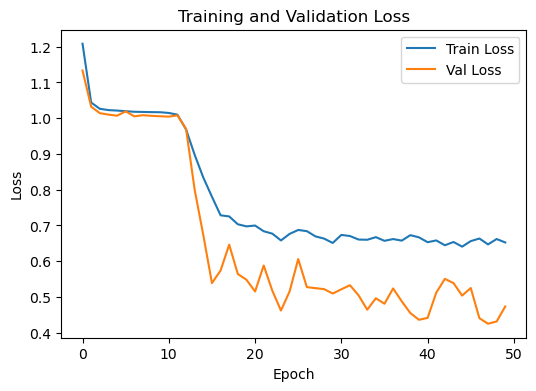

1/1 [==============================] - 0s 378ms/step


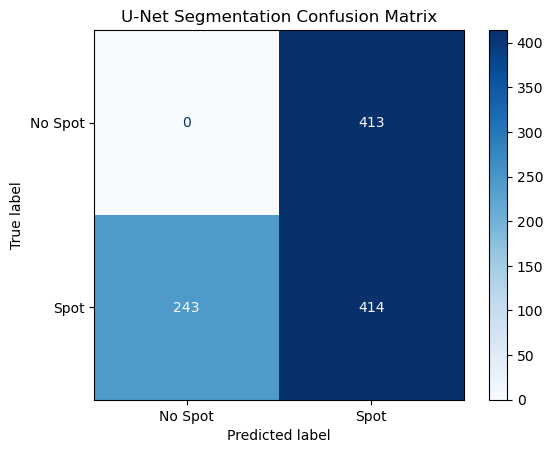

Overall accuracy: 99.87%
Overall F1 score: 0.558


In [3]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
from skimage.draw import disk
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf

# Ensure CPU only
tf.config.set_visible_devices([], 'GPU')


# Define the folder containing .spm files
folder_path = r"C:\Users\cobia\OneDrive - University of Cambridge\Python\afm_data\all_images_03_08_2025"

spm_files = [f for f in os.listdir(folder_path) if f.endswith('.spm')]


# Parameters
target_size = (256, 256)  # choose 512, 256, etc. depending on memory/time
img_size = target_size[0]  # assuming square images
scan_size_um = 3.0  # for coordinate conversion

def create_mask_from_labels(labels_df, img_shape):
    mask = np.zeros(img_shape, dtype=np.uint8)
    for _, row in labels_df.iterrows():
        y = img_shape[0] - 1 - int(row['y'])
        x = int(row['x'])
        if pd.isna(row['size']):
            radius = 3  # default radius if size missing
        else:
            radius = int(np.sqrt(row['size'] / np.pi))
        if 0 <= y < img_shape[0] and 0 <= x < img_shape[1]:
            rr, cc = disk((y, x), radius, shape=img_shape)
            mask[rr, cc] = 1
    return mask

def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) /
                (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth))

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

# =========================
# Load data
# =========================
X, Y = [], []
for filename in spm_files:
    afm_file = os.path.join(folder_path, f"{filename}_corrected.csv")
    label_file = os.path.join(folder_path, f"{os.path.splitext(filename)[0]}_categorised.csv")

    afm_data = pd.read_csv(afm_file, header=None).values.astype(np.float32)
    labels_df = pd.read_csv(label_file)
    mask = create_mask_from_labels(labels_df, afm_data.shape)

    # Resize AFM and mask to target_size
    afm_resized = resize(afm_data, target_size, preserve_range=True, anti_aliasing=True)
    mask_resized = resize(mask, target_size, order=0, preserve_range=True, anti_aliasing=False) > 0.5
    mask_resized = mask_resized.astype(np.uint8)

    # Normalize AFM to 0–1
    afm_norm = (afm_resized - afm_resized.min()) / (afm_resized.max() - afm_resized.min())

    X.append(afm_norm[..., np.newaxis])  # add channel dim
    Y.append(mask_resized[..., np.newaxis])

X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.float32)


# Train/test split
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y[:split_idx], Y[split_idx:]

# Parameters for Data Augmentation

BATCH_SIZE = 2
EPOCHS = 50

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.shuffle(buffer_size=100)
train_dataset = train_dataset.map(lambda x, y: augment(x, y), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# =========================
# Build lightweight U-Net
# =========================
def build_unet(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    # Bottleneck
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.UpSampling2D()(c4)
    u5 = layers.Concatenate()([u5, c3])
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(c5)

    u6 = layers.UpSampling2D()(c5)
    u6 = layers.Concatenate()([u6, c2])
    c6 = layers.Conv2D(32, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(32, 3, activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D()(c6)
    u7 = layers.Concatenate()([u7, c1])
    c7 = layers.Conv2D(16, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(16, 3, activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c7)

    model = models.Model(inputs, outputs)
    return model

model = build_unet((img_size, img_size, 1))
model.compile(optimizer=optimizers.Adam(1e-3), loss=bce_dice_loss, metrics=[Precision(), Recall()])

# =========================
# Train
# =========================
# history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=60, batch_size=2)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

# -------------------------
# Plot loss curves
# -------------------------
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# =========================
# Evaluate
# =========================
preds = (model.predict(X_test) > 0.5).astype(np.uint8)

# Flatten for metric calculation
y_true_flat = Y_test.flatten()
y_pred_flat = preds.flatten()

cm = confusion_matrix(y_true_flat, y_pred_flat)

# Replace TN with NaN if desired
cm_display = cm.astype(float)

cm_display[0, 0] = 0

disp = ConfusionMatrixDisplay(confusion_matrix=cm_display, display_labels=["No Spot", "Spot"])
fig, ax = plt.subplots()
disp.plot(cmap='Blues', ax=ax, values_format=".0f")

plt.title("U-Net Segmentation Confusion Matrix")
plt.show()

accuracy = np.mean(y_true_flat == y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)

print(f"Overall accuracy: {accuracy*100:.2f}%")
print(f"Overall F1 score: {f1:.3f}")


In [ ]:
cm_display = cm.astype(float)

cm_display[0, 0] = 0

disp = ConfusionMatrixDisplay(confusion_matrix=cm_display, display_labels=["No Spot", "Spot"])
fig, ax = plt.subplots()
disp.plot(cmap='Blues', ax=ax, values_format=".0f")

plt.title("U-Net Segmentation Confusion Matrix")
plt.show()

accuracy = np.mean(y_true_flat == y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)

print(f"Overall accuracy: {accuracy*100:.2f}%")
print(f"Overall F1 score: {f1:.3f}")

In [ ]:
plt.imshow(np.squeeze(preds[0]), cmap='gray')

In [ ]:
from skimage.measure import label, regionprops
from matplotlib.patches import Circle

# =========================
# Visualize predictions with circles
# =========================
for i in range(len(X_test)):
    afm = X_test[i, ..., 0]  # remove channel dim
    pred = preds[i, ..., 0]

    # Label connected regions in prediction
    labeled_pred = label(pred)
    regions = regionprops(labeled_pred)

    plt.figure(figsize=(10, 5))

    # Show AFM image with afmhot colormap
    plt.imshow(afm, cmap='afmhot')
    plt.title("AFM Image with Predicted Spots")
    plt.axis('off')

    # Overlay circles for each predicted spot
    ax = plt.gca()
    for region in regions:
        y, x = region.centroid
        radius = max(2, np.sqrt(region.area/np.pi))  # approximate radius
        circ = Circle((x, y), radius, edgecolor='blue', facecolor='none', linewidth=1.5)
        ax.add_patch(circ)

    plt.show()


In [ ]:
# =========================
# Visualize predictions with afmhot colormap
# =========================
def overlay_predictions_afmhot(afm_img, pred_mask, alpha=0.9, spot_color=(0, 0, 1)):
    """
    Overlay binary mask on AFM image using afmhot colormap.
    
    Parameters:
        afm_img: 2D array, normalized AFM image (0-1)
        pred_mask: 2D array, binary prediction mask
        alpha: transparency of overlay
        spot_color: RGB tuple for spots
    """
    # Map AFM image to RGB using afmhot
    afm_rgb = plt.cm.afmhot(afm_img)[..., :3]  # drop alpha channel

    # Overlay mask
    overlay = afm_rgb.copy()
    overlay[pred_mask == 1] = (1-alpha)*afm_rgb[pred_mask==1] + alpha*np.array(spot_color)
    return overlay

# Show all test images with predictions
for i in range(len(X_test)):
    afm = X_test[i, ..., 0]  # remove channel dim
    pred = preds[i, ..., 0]

    overlay_img = overlay_predictions_afmhot(afm, pred, alpha=0.4)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(afm, cmap='afmhot')
    plt.title("AFM Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlay_img)
    plt.title("U-Net Predicted Spots")
    plt.axis('off')

    plt.show()


In [ ]:
cm

## CNN Training Time

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models

# -------------------------
# Parameters
# -------------------------
cutout_size = 19
half_size = cutout_size // 2

X = []
y = []

# -------------------------
# Data extraction
# -------------------------
for filename in spm_files:
    afm_file = os.path.join(folder_path, f"{filename}_corrected.csv")
    label_file = os.path.join(folder_path, f"{os.path.splitext(filename)[0]}_categorised.csv")

    afm_data = pd.read_csv(afm_file, header=None).values
    labels = pd.read_csv(label_file)

    # Spot cutouts (label=1)
    for _, row in labels.iterrows():
        if row['category'] not in ['large', 'small']:
            continue
        cx, cy = int(row['x']), int(row['y'])
        # Flip y for correct orientation
        cy = afm_data.shape[0] - 1 - cy
        if cx - half_size < 0 or cx + half_size >= afm_data.shape[1] or cy - half_size < 0 or cy + half_size >= afm_data.shape[0]:
            continue  # skip if too close to border
        patch = afm_data[cy - half_size:cy + half_size + 1, cx - half_size:cx + half_size + 1]
        X.append(patch)
        # y.append(1)

        if row['category'] == 'large':
            y.append(1)
        else:
            y.append(0)

    ## ---- Uncomment below lines for spot/no-spot training (also remove the if 'large' statement above)

    # No-spot cutouts (label=0)
    # Sample random positions far from labeled spots
    # mask = np.zeros_like(afm_data, dtype=bool)
    # for _, row in labels.iterrows():
    #     rr, cc = int(row['y']), int(row['x'])
    #     rr = afm_data.shape[0] - 1 - rr
    #     yy, xx = np.ogrid[:afm_data.shape[0], :afm_data.shape[1]]
    #     dist = np.sqrt((xx - cc)**2 + (yy - rr)**2)
    #     mask[dist <= half_size] = True

    # n_neg_samples = len(labels)  # balance positives and negatives
    # neg_coords = np.argwhere(~mask)
    # np.random.shuffle(neg_coords)
    # for ny, nx in neg_coords[:n_neg_samples]:
    #     if nx - half_size < 0 or nx + half_size >= afm_data.shape[1] or ny - half_size < 0 or ny + half_size >= afm_data.shape[0]:
    #         continue
    #     patch = afm_data[ny - half_size:ny + half_size + 1, nx - half_size:nx + half_size + 1]
    #     X.append(patch)
    #     y.append(0)

    ## ----- end spot/no-spot section

# Convert to arrays
X = np.array(X)
y = np.array(y)

# Normalise height values
X = (X - np.mean(X)) / np.std(X)
X = X[..., np.newaxis]  # add channel dimension


In [ ]:

# -------------------------
# Train/test split
# -------------------------
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# -------------------------
# CNN model
# -------------------------
# model = models.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(cutout_size, cutout_size, 1)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(1, activation='sigmoid')  # binary classification
# ])

# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# -------------------- OLD Model -----------

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(cutout_size, cutout_size, 1)),  # Updated input_shape to (15, 15, 3)
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# -------------------------
# Training
# -------------------------
history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                    validation_data=(X_val, y_val))

# -------------------------
# Plot loss curves
# -------------------------
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()



In [ ]:
patch

In [ ]:
prediction = model.predict(patch.reshape((None, 19, 19, 1)), verbose=1)[0][0]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import os
from tensorflow.keras.models import load_model

def visualize_labeled_spot_predictions(model, afm_file, label_file, cutout_size=19):
    """
    Visualizes large and small spot predictions for patches centered on ground truth labels.
    - Predictions are shown with solid circles.
    - Ground truth labels are shown with dashed circles.
    - Correct predictions are green, incorrect are red.
    """
    half_size = cutout_size // 2

    try:
        afm_data = pd.read_csv(afm_file, header=None).values
        labels_df = pd.read_csv(label_file)
    except FileNotFoundError:
        print(f"Error: Could not find files {afm_file} or {label_file}. Please check the paths.")
        return

    height, width = afm_data.shape

    # Store results for plotting
    correct_predictions = []
    incorrect_predictions = []

    # Iterate through each spot defined in the label file
    for index, row in labels_df.iterrows():
        print(f"Processing label {index + 1}/{len(labels_df)}: {row['category']} at ({row['x']}, {row['y']})")
        # Only process 'large' or 'small' spots
        if row['category'] not in ['large', 'small']:
            continue
        
        # Get coordinates from the label file
        cx, cy = int(row['x']), int(row['y'])
        
        # Adjust y-coordinate to match the image data's orientation
        cy_data = height - 1 - cy

        # Skip if patch is too close to the border
        if cx - half_size < 0 or cx + half_size >= width or cy_data - half_size < 0 or cy_data + half_size >= height:
            continue
        
        # Extract, normalize, and reshape the patch
        patch = afm_data[cy_data - half_size:cy_data + half_size + 1, cx - half_size:cx + half_size + 1]
        patch = (patch - np.mean(patch)) / np.std(patch)
        patch = patch[np.newaxis, ..., np.newaxis]

        # Make a prediction
        prediction = model.predict(patch, verbose=0)[0][0]
        predicted_class = 1 if prediction > 0.5 else 0
        true_class = 1 if row['category'] == 'large' else 0

        # Store the result for plotting
        if predicted_class == true_class:
            correct_predictions.append({'coords': (cx, cy), 'pred': predicted_class, 'true': true_class})
        else:
            incorrect_predictions.append({'coords': (cx, cy), 'pred': predicted_class, 'true': true_class})

    # Plot the full image
    plt.figure(figsize=(10, 10))
    plt.imshow(afm_data, cmap='viridis')
    plt.title('CNN Predictions on Labeled Spots')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    ax = plt.gca()

    # Plot ground truth labels (dashed circles)
    for _, row in labels_df.iterrows():
        if row['category'] not in ['large', 'small']:
            continue
        cx, cy = int(row['x']), int(row['y'])
        cy_plot = height - 1 - cy
        
        color = 'red' if row['category'] == 'large' else 'blue'
        circle_truth = Circle((cx, cy_plot), radius=half_size, color=color, fill=False, linewidth=1, linestyle='--')
        ax.add_patch(circle_truth)

    # Plot correct predictions (green solid circles)
    for pred in correct_predictions:
        cx, cy = pred['coords']
        cy_plot = height - 1 - cy
        circle = Circle((cx, cy_plot), radius=half_size, color='green', fill=False, linewidth=2)
        ax.add_patch(circle)

    # Plot incorrect predictions (red solid circles)
    for pred in incorrect_predictions:
        cx, cy = pred['coords']
        cy_plot = height - 1 - cy
        circle = Circle((cx, cy_plot), radius=half_size, color='red', fill=False, linewidth=2)
        ax.add_patch(circle)

    # Create a custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='green', lw=2, label='Correct Prediction'),
        Line2D([0], [0], color='red', lw=2, label='Incorrect Prediction'),
        Line2D([0], [0], color='black', lw=1, linestyle='--', label='Ground Truth Label (Large=Red, Small=Blue)')
    ]
    ax.legend(handles=legend_elements)

    plt.show()

# --- Example Usage ---
# Assuming your model is trained and available.
# Replace with your actual file paths.
# example_afm_file = 'path/to/your/image_corrected.csv'
# example_label_file = 'path/to/your/image_categorised.csv'

# Example call:
# visualize_labeled_spot_predictions(model, example_afm_file, example_label_file)

# Example call (assuming the files are in the same directory):
visualize_large_small_predictions(model, r"C:\Users\cobia\OneDrive - University of Cambridge\Python\afm_data\all_images_03_08_2025\Si_L_longend_05.0_00000_game.spm_corrected.csv", r"C:\Users\cobia\OneDrive - University of Cambridge\Python\afm_data\all_images_03_08_2025\Si_L_longend_05.0_00000_game_categorised.csv")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# -------------------------
# Predictions
# -------------------------
y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# -------------------------
# Confusion matrix
# -------------------------
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Small', 'Large'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# -------------------------
# Metrics
# -------------------------
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, zero_division=0)
recall = recall_score(y_val, y_pred, zero_division=0)
f1 = f1_score(y_val, y_pred, zero_division=0)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


In [ ]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score, classification_report
)
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# Predictions
# -------------------------
y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# -------------------------
# Confusion matrix
# -------------------------
labels = ['Small', 'Large']
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)

# -------------------------
# Metrics
# -------------------------
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='binary', zero_division=0)
recall = recall_score(y_val, y_pred, average='binary', zero_division=0)
f1 = f1_score(y_val, y_pred, average='binary', zero_division=0)

# Per-class metrics
class_prec = precision_score(y_val, y_pred, average=None, zero_division=0)
class_rec = recall_score(y_val, y_pred, average=None, zero_division=0)
class_f1 = f1_score(y_val, y_pred, average=None, zero_division=0)

# Build annotation text
textstr = f"Overall:\n" \
          f"Acc: {accuracy:.3f}\n" \
          f"Prec: {precision:.3f}\n" \
          f"Rec: {recall:.3f}\n" \
          f"F1: {f1:.3f}\n\n" \
          f"Per-class:\n" \
          f"{labels[0]} - P:{class_prec[0]:.2f}, R:{class_rec[0]:.2f}, F1:{class_f1[0]:.2f}\n" \
          f"{labels[1]} - P:{class_prec[1]:.2f}, R:{class_rec[1]:.2f}, F1:{class_f1[1]:.2f}"

# Add text box to plot
ax.text(1.05, 0.5, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# Predictions
# -------------------------
y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# -------------------------
# Confusion matrix
# -------------------------
labels = ['Small', 'Large']
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(7, 7))
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)

# -------------------------
# Metrics
# -------------------------
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='binary', zero_division=0)
recall = recall_score(y_val, y_pred, average='binary', zero_division=0)
f1 = f1_score(y_val, y_pred, average='binary', zero_division=0)

# Per-class metrics
class_prec = precision_score(y_val, y_pred, average=None, zero_division=0)
class_rec = recall_score(y_val, y_pred, average=None, zero_division=0)
class_f1 = f1_score(y_val, y_pred, average=None, zero_division=0)

# -------------------------
# Create metrics table data
# -------------------------
table_data = [
    ["Metric", "Overall", labels[0], labels[1]],
    ["Accuracy", f"{accuracy:.3f}", "", ""],
    ["Precision", f"{precision:.3f}", f"{class_prec[0]:.3f}", f"{class_prec[1]:.3f}"],
    ["Recall", f"{recall:.3f}", f"{class_rec[0]:.3f}", f"{class_rec[1]:.3f}"],
    ["F1 Score", f"{f1:.3f}", f"{class_f1[0]:.3f}", f"{class_f1[1]:.3f}"]
]

# -------------------------
# Add table below the confusion matrix
# -------------------------
ax_table = plt.gcf().add_axes([0.15, -0.35, 0.7, 0.25])  # position: [left, bottom, width, height]
ax_table.axis('off')

table = ax_table.table(
    cellText=table_data,
    cellLoc='center',
    colLabels=None,
    loc='center'
)

# Style table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

# Color header row
for col in range(len(table_data[0])):
    table[(0, col)].set_facecolor('#1f77b4')
    table[(0, col)].set_text_props(color='white', weight='bold')

# Color first column
for row in range(len(table_data)):
    table[(row, 0)].set_facecolor('#c6dcee')
    table[(row, 0)].set_text_props(weight='bold')

plt.subplots_adjust(bottom=0.1)  # make space for table
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get predictions (probabilities)
y_pred_probs = model.predict(X_val)

# Convert to binary labels
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Find incorrect predictions
incorrect_indices = np.where(y_pred != y_val)[0]
correct_indices = np.where(y_pred == y_val)[0]

print(f"Number of misclassified images: {len(incorrect_indices)}")

labels = ['No Spot', 'Spot']

# Display them
plt.figure(figsize=(5, 5))
for i, idx in enumerate(correct_indices[[0,1,3,4]]):
    plt.subplot(2, 2, i+1)  # 5x5 grid, adjust as needed
    plt.imshow(X_val[idx].squeeze(), cmap='gray')
    plt.title(f"True: {labels[y_val[idx]]}, Pred: {labels[y_pred[idx]]}", fontsize=10)
    plt.axis('off')
    if i >= 3:  # limit to first 25 for display
        break

plt.tight_layout()
plt.show()


In [ ]:
plt.close('all')

In [ ]:
plt.imshow(X[0,:,:,:], cmap='gray')

In [ ]:
np.unique(y, return_counts=True)